<a href="https://colab.research.google.com/github/Victoria-Komarnitckaia/awesomeProject1/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_(%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Автокодировщик для базы лиц** 

Имеется база с изображениями лиц в размере 5018 цветных фото. 
На основании этой базы было проведено исследование по созданию автокодировщиков по подавлению шума на фото, а также перекрашиванию черно-белых изображений в цветные.  

###  **Получение изображений в градациях серого** 

In [1]:
# Импортируем необходимые библиотеки 
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os
import time

from tensorflow.python.keras.callbacks import LambdaCallback
from tensorflow.python.keras.callbacks import LearningRateScheduler
from IPython.display import clear_output

from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Conv1D, BatchNormalization, Dropout, Flatten, Input, concatenate, Reshape, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.preprocessing import image

from tensorflow.keras.utils import plot_model    #plot_model (model, show_shapes=True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/Базы/Лица.zip' #Файл с базой лиц

In [4]:
img_direct = 'Лица'  #Задаем имя папки, в которую распаковали изображения 
img_height = 112
img_width = 80 

In [5]:
#Функция для загрузки фото в градации серого 
def load_img_gray (img_dir, img_height, img_width):
  list_images = []
  for img in os.listdir (img_dir):
    list_images.append(image.img_to_array(image.load_img(os.path.join(img_dir,img),
                       target_size = (img_height, img_width), 
                       color_mode = 'grayscale')))
  return np.array (list_images)

In [6]:
curr_time = time.time()
X_train_image = load_img_gray (img_direct, img_height, img_width)
print ('Время загрузки: ', round(time.time() - curr_time, 2), 'c', sep = '')

Время загрузки: 36.71c


In [7]:
X_train_image.shape

(5018, 112, 80, 1)

In [8]:
x_train_gray = X_train_image/255 # отнормируем изображения от 0 до 1

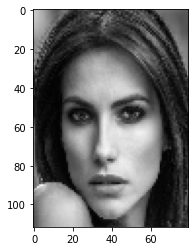

In [74]:
plt.imshow (x_train_gray  [np.random.randint (0, x_train_gray.shape[0])].reshape(112,80), cmap = 'gray')

In [75]:
x_train_gray.shape

(5018, 112, 80, 1)

In [76]:
#Функция базового автокодировщика 
def baseAutoEncoder (shape = (112,80,1)):
  img_input = Input ((shape))

  x = Conv2D (32, (3,3), padding = 'same', activation = 'relu') (img_input)
  x = BatchNormalization () (x)
  x = Conv2D (32, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)
  x = MaxPooling2D () (x)

  x = Conv2D (64, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)
  x = Conv2D (64, (3,3), padding = 'same', activation = 'relu') (x)
  z = MaxPooling2D () (x)

  x = Conv2DTranspose (64, (2,2), strides = (2,2), padding = 'same', activation = 'relu') (z)
  x = BatchNormalization () (x)

  x = Conv2D (64, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)
  x = Conv2D (64, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)

  x = Conv2DTranspose (32, (2,2), strides = (2,2), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)
  x = Conv2D (32, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)
  x = Conv2D (32, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)

  x = Conv2D (1, (3,3), padding = 'same', activation = 'sigmoid') (x)

  model = Model (img_input, x)
  model.compile (loss = 'mse', optimizer = Adam (lr = 1e-4))

  return model

In [77]:
#Функция для отображения исходного и получившегося варианта 
def plot_image (xTrain, pred, shape = (112,80)):
  n = 5
  plt.figure (figsize = (10, 4))
  for i in range (n):
    # показываем картинки из обучающего набора 
    index = np.random.randint (0, pred.shape[0])
    ax = plt.subplot (2, n, i+1)   #i+1 - позиция индекса
    plt.imshow (xTrain[index].reshape (shape))
    plt.gray ()
    ax.get_xaxis().set_visible (False)  #скрываем вывод координатной оси
    ax.get_yaxis().set_visible (False)

    #показываем восстановленные картики
    ax = plt.subplot (2, n, i + 1 + n)
    plt.imshow (pred[index].reshape (shape))
    plt.gray
    ax.get_xaxis().set_visible (False)
    ax.get_yaxis().set_visible (False)

  plt.show   

In [78]:
#Функция среднеквадратичной ошибки
def getMSE (x1, x2):
  x1 = x1.flatten()
  x2 = x2.flatten()
  delta = x1 - x2
  return sum (delta**2)/len(delta)

In [96]:
#Функция выведения ошибки на экран
def getFaceAccByBias (xTrain_img, predFase, bias, section = 80):
  errFase = [getMSE(xTrain_img[i], predFase[i] / 255) for i in range(len(predFase))] # посчитаем ошибку для всех изображений
  
  isFase = [e < bias for e in errFase[section:]] # запишем каждую ошибку больше порогового значения

  
  print("Ошибка на Лицах:", errFase[:10]) #посмотрим последние 10
  print("Средняя ошибка на Лицах:", round(sum(errFase[section:]) / len(errFase[section:]), 4)) # посчитаем для последних 80 среднюю ошибку
  print("Минимальная ошибка на Лицах:", round(min(errFase),4)) #найдем минимальную ошибку
  print("Лица распознаны, как Лица: ", round(100*sum(isFase) / len(isFase)),"%", sep="")

In [81]:
modelAutoFase = baseAutoEncoder()
modelAutoFase.fit (x_train_gray [:4100],x_train_gray [:4100], 
                   epochs = 150, batch_size = 100, 
                   validation_data = (x_train_gray [918:], x_train_gray [918:]))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
41/41 [==============================] - 32s 496ms/step - loss: 0.0478 - val_loss: 0.0687
Epoch 2/150
41/41 [==============================] - 19s 466ms/step - loss: 0.0134 - val_loss: 0.0697
Epoch 3/150
41/41 [==============================] - 19s 468ms/step - loss: 0.0082 - val_loss: 0.0710
Epoch 4/150
41/41 [==============================] - 20s 486ms/step - loss: 0.0065 - val_loss: 0.0687
Epoch 5/150
41/41 [==============================] - 19s 470ms/step - loss: 0.0055 - val_loss: 0.0664
Epoch 6/150
41/41 [==============================] - 20s 486ms/step - loss: 0.0048 - val_loss: 0.0591
Epoch 7/150
41/41 [==============================] - 20s 485ms/step - loss: 0.0045 - val_loss: 0.0508
Epoch 8/150
41/41 [==============================] - 20s 485ms/step - loss: 0.0043 - val_loss: 0.0424
Epoch 9/150
41/41 [==============================] - 19s 468ms/step - loss: 0.0040 - val_loss: 0.0335
Epoch 10/150
41/41 [==============================] - 19s 469ms/step - loss: 0.003

In [82]:
modelAutoFase.save_weights ('/content/drive/My Drive/Colab Notebooks/Базы/modelAutoFase_11.h5')
#modelAutoFase.load_weights ('/content/drive/My Drive/Colab Notebooks/Базы/modelAutoFase_11.h5')

In [83]:
predFase = modelAutoFase.predict (x_train_gray [:4000]) #проверим 100 последних картинок 

predFase = predFase * 255   # представляем в виде значений от 0 до 255
predFase = predFase.astype ('uint8')

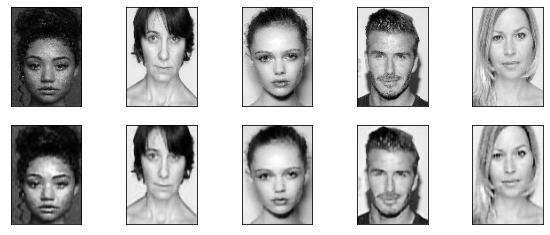

In [87]:
plot_image (x_train_gray, predFase)

In [97]:
getFaceAccByBias (x_train_gray, predFase, 0.005, section = 80)

Ошибка на Лицах: [0.0010877068035647468, 0.001117037902819116, 0.0011616979268951313, 0.0009184621062852121, 0.0029710707449352135, 0.0010425507404528262, 0.0011971685050947882, 0.001437749052585353, 0.0010415963955182537, 0.001194902769225207]
Средняя ошибка на Лицах: 0.0013
Минимальная ошибка на Лицах: 0.0003
Лица распознаны, как Лица: 99%


## **Удаление шума**

In [98]:
def addNoise (x, noiseVal):
  noise = np.random.normal (loc = 0.5, scale = 0.5, size = x.shape)
  return np.clip (x + noiseVal*noise, 0., 1.)

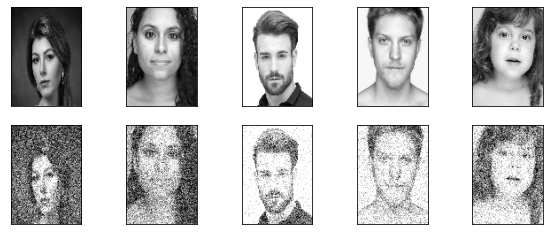

In [99]:
noised_x_train_face = addNoise (x_train_gray, 0.4) #создаем базу фото с шумом
plot_image (x_train_gray, noised_x_train_face)

In [100]:
def denoiseAutoEncoder ():
  img_input = Input ((112,80,1))

  x = Conv2D (32, (3,3), strides = 2, padding = 'same', activation = 'relu') (img_input)
  x = Conv2D (64, (3,3), strides = 2, padding = 'same', activation = 'relu') (x)
  x = Conv2D (128, (3,3), strides = 2, padding = 'same', activation = 'relu') (x)
  x = Conv2D (256, (3,3), strides = 2, padding = 'same', activation = 'relu') (x)
  x = Flatten () (x)
  z = Dense (256, activation = 'relu') (x)
  x = Dense (7*5*256, activation = 'relu') (z)
  x = Reshape ((7,5,256)) (x)
  x = Conv2DTranspose (256, (3,3), strides = 2, padding = 'same') (x)
  x = Conv2DTranspose (128, (3,3), strides = 2, padding = 'same') (x)
  x = Conv2DTranspose (64, (3,3), strides = 2, padding = 'same') (x)
  x = Conv2DTranspose (32, (3,3), strides = 2, padding = 'same') (x)
  x = Conv2D (1, (3,3), activation = 'sigmoid', padding = 'same') (x)

  model = Model (img_input, x)
  model.compile (loss = 'mse', optimizer = Adam())

  return model

In [101]:
modelDenoiseFace = denoiseAutoEncoder ()
modelDenoiseFace.fit (noised_x_train_face[:4700], x_train_gray[:4700],
                      batch_size = 100,
                      epochs = 80,
                      validation_data = (noised_x_train_face[4700:], x_train_gray[4700:]))

Epoch 1/80
47/47 [==============================] - 11s 191ms/step - loss: 0.0567 - val_loss: 0.0380
Epoch 2/80
47/47 [==============================] - 8s 180ms/step - loss: 0.0255 - val_loss: 0.0195
Epoch 3/80
47/47 [==============================] - 9s 182ms/step - loss: 0.0162 - val_loss: 0.0149
Epoch 4/80
47/47 [==============================] - 8s 179ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 5/80
47/47 [==============================] - 8s 180ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 6/80
47/47 [==============================] - 8s 179ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 7/80
47/47 [==============================] - 8s 179ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 8/80
47/47 [==============================] - 8s 179ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 9/80
47/47 [==============================] - 8s 179ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 10/80
47/47 [==============================] - 8s 179ms/step - loss: 0.0084 - val_loss: 0.008

In [102]:
predFaceDenoise = modelDenoiseFace.predict (noised_x_train_face[:4000])
predFaseDenoise = predFaceDenoise * 255 # представляем в виде значений от 0 до 255
predFaseDenoise = predFaseDenoise.astype('uint8') # устанавливаем 8битовый тип

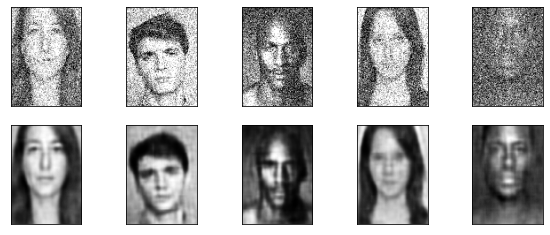

In [103]:
plot_image (noised_x_train_face, predFaseDenoise)

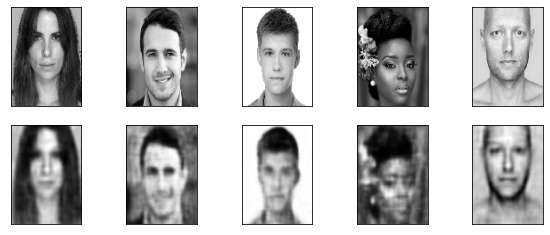

In [104]:
plot_image (x_train_gray, predFaseDenoise)

## **Перекрашивание изображений**

In [105]:
#Функция для загрузки цветных фото 

def load_img_color (img_dir, img_height, img_width):
  list_images = []
  for img in os.listdir (img_dir):
    list_images.append(image.img_to_array(image.load_img(os.path.join(img_dir,img),
                       target_size = (img_height, img_width))))
  return np.array (list_images)

In [106]:
curr_time = time.time()
xTrain_imag = load_img_color (img_direct, img_height, img_width)
print ('Время загрузки: ', round(time.time() - curr_time, 2), 'c', sep = '')

Время загрузки: 34.86c


In [107]:
x_train_color = xTrain_imag/255 # отнормируем изображения от 0 до 1

In [108]:
x_train_color.shape

(5018, 112, 80, 3)

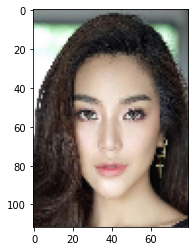

In [145]:
plt.imshow (x_train_color  [np.random.randint (0, x_train_color.shape[0])])

In [146]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 9)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index]) # отрисуем обработанные сеткой картинки в размере 112*80     
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [147]:
def colorAutoEncoder(): # объявляем функцию создания автокодировщика для подавления шума
    img_input = Input((112,80,1)) # задаём входные размеры

    # Добавляем четыре сверточных слоя, вместо MaxPooling используем strides
    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x) # сплющиваем в одномерный вектор - размер 7*5*256
    z = Dense(256, activation='relu')(x) # добавляем полносвязный слой
    x = Dense(7*5*256, activation='relu')(z) # и еще полносвязный слой с переводом в 8960-мерное пространство(7*5*256)
    x = Reshape((7,5,256))(x) # меняем размеры - картинка 7*5 , 256 ядер
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 7*5 до 14*10
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 14*10 до 28*20
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 28*20 до 56*40
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 56*40 до 112*80
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) # и пропускаем через финальный слой двумерной свертки

    model = Model(img_input, x) # собрали модель с зашумленной картинкой на вход и с очищенной от шума на выход
    model.compile(optimizer='adam',
                  loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки

    return model # функция вернет модель подавления шума

In [148]:
modelColoredFase = colorAutoEncoder()
modelColoredFase.fit (x_train_gray [:4700],x_train_color [:4700], 
                   epochs = 150, batch_size = 100, 
                   validation_data = (x_train_gray [4700:], x_train_color [4700:]))

Epoch 1/150
47/47 [==============================] - 11s 202ms/step - loss: 0.0600 - val_loss: 0.0414
Epoch 2/150
47/47 [==============================] - 9s 196ms/step - loss: 0.0271 - val_loss: 0.0203
Epoch 3/150
47/47 [==============================] - 9s 196ms/step - loss: 0.0173 - val_loss: 0.0152
Epoch 4/150
47/47 [==============================] - 9s 194ms/step - loss: 0.0143 - val_loss: 0.0136
Epoch 5/150
47/47 [==============================] - 9s 195ms/step - loss: 0.0128 - val_loss: 0.0124
Epoch 6/150
47/47 [==============================] - 9s 195ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 7/150
47/47 [==============================] - 9s 194ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 8/150
47/47 [==============================] - 9s 194ms/step - loss: 0.0105 - val_loss: 0.0107
Epoch 9/150
47/47 [==============================] - 9s 195ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 10/150
47/47 [==============================] - 9s 194ms/step - loss: 0.0094 - val_l

In [ ]:
modelColoredFase.save_weights ('/content/drive/My Drive/Colab Notebooks/Базы/modelColoredFase_1.h5')
#modelColoredFase.load_weights ('/content/drive/My Drive/Colab Notebooks/Базы/modelColoredFase_1.h5')

In [149]:
predFase_color = modelColoredFase.predict (x_train_gray [:4000]) #проверим 4000 ппервых картинок 

#predFase_color = predFase * 255   # представляем в виде значений от 0 до 255
#predFase_color = predFase.astype ('uint8')

In [150]:
predFase_color.shape

(4000, 112, 80, 3)

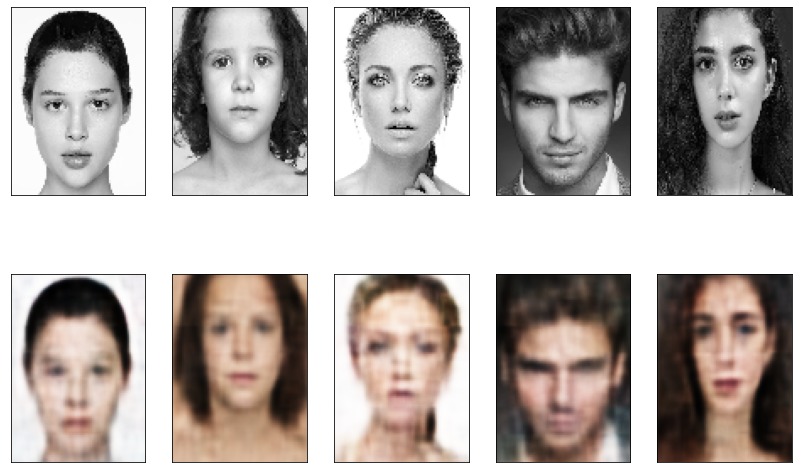

In [151]:
plotImages (x_train_gray, predFase_color)

Вариант нейронки №2 (работает лучше)

In [156]:
def ColorAutoEncoder2 (shape = (112,80,1)):
  img_input = Input ((shape))

  x = Conv2D (32, (3,3), padding = 'same', activation = 'relu') (img_input)
  x = BatchNormalization () (x)
  x = Conv2D (32, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)
  x = MaxPooling2D () (x)

  x = Conv2D (64, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)
  x = Conv2D (64, (3,3), padding = 'same', activation = 'relu') (x)
  z = MaxPooling2D () (x)

  x = Conv2DTranspose (64, (2,2), strides = (2,2), padding = 'same', activation = 'relu') (z)
  x = BatchNormalization () (x)

  x = Conv2D (64, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)
  x = Conv2D (64, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)

  x = Conv2DTranspose (32, (2,2), strides = (2,2), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)
  x = Conv2D (32, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)
  x = Conv2D (32, (3,3), padding = 'same', activation = 'relu') (x)
  x = BatchNormalization () (x)

  x = Conv2D (3, (3,3), padding = 'same', activation = 'sigmoid') (x)

  model = Model (img_input, x)
  model.compile (loss = 'mse', optimizer = Adam (lr = 1e-4))

  return model

In [ ]:
modelColoredFase_1 = ColorAutoEncoder2 ()
modelColoredFase_1.fit (x_train_gray [:4700],x_train_color [:4700], 
                   epochs = 150, batch_size = 100, 
                   validation_data = (x_train_gray [4700:], x_train_color [4700:]))

Epoch 1/150
47/47 [==============================] - 3s 63ms/step - loss: 0.0523 - val_loss: 0.0697
Epoch 2/150
47/47 [==============================] - 3s 57ms/step - loss: 0.0156 - val_loss: 0.0677
Epoch 3/150
47/47 [==============================] - 3s 57ms/step - loss: 0.0109 - val_loss: 0.0660
Epoch 4/150
47/47 [==============================] - 3s 57ms/step - loss: 0.0090 - val_loss: 0.0629
Epoch 5/150
47/47 [==============================] - 3s 57ms/step - loss: 0.0080 - val_loss: 0.0590
Epoch 6/150
47/47 [==============================] - 3s 57ms/step - loss: 0.0073 - val_loss: 0.0532
Epoch 7/150
47/47 [==============================] - 3s 57ms/step - loss: 0.0068 - val_loss: 0.0434
Epoch 8/150
47/47 [==============================] - 3s 57ms/step - loss: 0.0063 - val_loss: 0.0314
Epoch 9/150
47/47 [==============================] - 3s 57ms/step - loss: 0.0060 - val_loss: 0.0235
Epoch 10/150
47/47 [==============================] - 3s 57ms/step - loss: 0.0058 - val_loss: 0.0172

In [ ]:
modelColoredFase.save_weights ('/content/drive/My Drive/Colab Notebooks/Базы/modelColoredFase_12.h5')
#modelColoredFase.load_weights ('/content/drive/My Drive/Colab Notebooks/Базы/modelColoredFase_12.h5')

In [ ]:
predFase_color_1 = modelColoredFase_1.predict (x_train_gray [:4000])

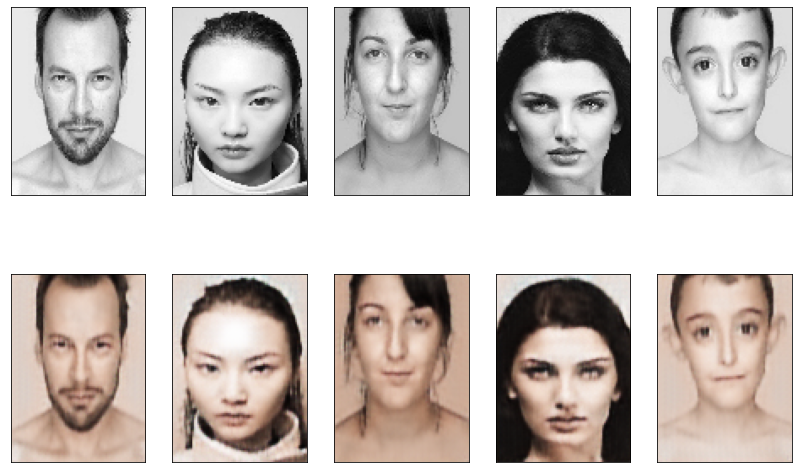

In [ ]:
plotImages (x_train_gray, predFase_color_1)

Вариант №3 с преобразованием данных из формата RGB в формат LAB

 *(ЛУЧШИЙ ВАРИАНТ*)

In [152]:
#функция просмотра min max значений цветов 
def plotMinMax(x_train_color,labels=["R","G","B"]):
    print("______________________________")
    for i, lab in enumerate(labels):
        mi = np.min(x_train_color[:,:,:,i])
        ma = np.max(x_train_color[:,:,:,i])
        print("{} : MIN={:8.4f}, MAX={:8.4f}".format(lab,mi,ma))
        
plotMinMax(x_train_color,labels=["R","G","B"])    

______________________________
R : MIN=  0.0000, MAX=  1.0000
G : MIN=  0.0000, MAX=  1.0000
B : MIN=  0.0000, MAX=  1.0000


In [153]:
#преобразование картинок в формат LAB
from skimage.color import rgb2lab, lab2rgb
Xsub_lab = rgb2lab(x_train_color)
plotMinMax(Xsub_lab,labels=["L","A","B"])

______________________________
L : MIN=  0.0000, MAX=100.0000
A : MIN=-65.5328, MAX= 83.7712
B : MIN=-86.1590, MAX= 89.1755


In [154]:
Xsub_lab.shape

(5018, 112, 80, 3)

In [157]:
modelColoredFase2 = ColorAutoEncoder2 ()
modelColoredFase2.fit (x_train_gray [:4700],Xsub_lab [:4700], 
                   epochs = 150, batch_size = 100, 
                   validation_data = (x_train_gray [4700:], Xsub_lab [4700:]))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
47/47 [==============================] - 20s 396ms/step - loss: 1298.8795 - val_loss: 1300.4574
Epoch 2/150
47/47 [==============================] - 18s 384ms/step - loss: 1291.7823 - val_loss: 1291.5955
Epoch 3/150
47/47 [==============================] - 18s 383ms/step - loss: 1289.0376 - val_loss: 1287.3062
Epoch 4/150
47/47 [==============================] - 18s 382ms/step - loss: 1287.5155 - val_loss: 1285.7034
Epoch 5/150
47/47 [==============================] - 18s 382ms/step - loss: 1286.6158 - val_loss: 1285.0336
Epoch 6/150
47/47 [==============================] - 18s 382ms/step - loss: 1286.0099 - val_loss: 1284.7609
Epoch 7/150
47/47 [==============================] - 18s 381ms/step - loss: 1285.5580 - val_loss: 1284.6604
Epoch 8/150
47/47 [==============================] - 18s 382ms/step - loss: 1285.2131 - val_loss: 1284.5547
Epoch 9/150
47/47 [==============================] - 18s 387ms/step - loss: 1284.9567 - val_loss: 1284.4985
Epoch 10/150
47/47 [========

In [163]:
modelColoredFase.save_weights ('/content/drive/My Drive/Colab Notebooks/Базы/modelColoredFase_22.h5')
#modelColoredFase.load_weights ('/content/drive/My Drive/Colab Notebooks/Базы/modelColoredFase_22.h5')

In [158]:
predFase_color_2 = modelColoredFase2.predict (x_train_gray [:4000])

In [159]:
predFase_color_2.shape

(4000, 112, 80, 3)

In [160]:
#Преобразуем формат LAB в формат RGB, чтобы отобразить получившуюся картинку 
Xsub_lab_rgb = np.zeros(predFase_color_2.shape)
for i in range(predFase_color_2.shape[0]):
    Xsub_lab_rgb[i] = lab2rgb(Xsub_lab[i])

In [161]:
Xsub_lab_rgb.shape

(4000, 112, 80, 3)

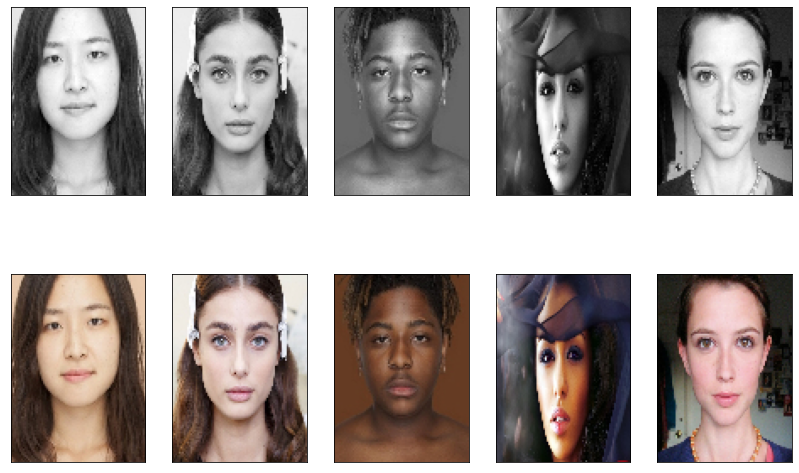

In [162]:
plotImages (x_train_gray, Xsub_lab_rgb)